In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.gridspec as gridspec
from scipy.stats import multivariate_normal

In [2]:
# import internal files
import emulator
import kernels
import data
import historymatch
import plot

In [3]:
def model_eqn(x, y):
    #return np.cos(np.sqrt(x**2 + 2*y**2))
    #return np.cos(x)* ( (x**2+2*y**2)**0.5 )     # doughnuty shape with 0.1,0.3
    return 12*(np.cos(3*y**3 + x**2))/(x**2 + y**2 + 3)
    #return (1/())
    
model = np.vectorize(model_eqn)

In [4]:
# define parameter space
x_bound = np.array([-4, 4]).reshape(1,-1)
y_bound = np.array([-4, 4]).reshape(1,-1)
input_bounds = np.concatenate((x_bound, y_bound), axis=0)

xvals = np.linspace(input_bounds[0,0], input_bounds[0,1], 100)
yvals = np.linspace(input_bounds[1,0], input_bounds[1,1], 100)

In [5]:
# for testing: true datapoints
true_x = 0.8
true_y = 0
true_parameters = [true_x, true_y]
var_exp = 0.1        # observational uncertainty variance
z_1 = model_eqn(true_x, true_y) + np.random.normal(0,var_exp) # observed datapoint

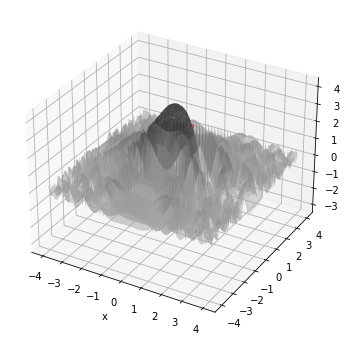

In [6]:
xy_grid = np.zeros((len(xvals), len(yvals)))

X, Y = np.meshgrid(xvals, yvals)
func_grid = model(X, Y)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')

ax.plot_surface(X, Y, func_grid, cmap='binary', alpha=0.5)
ax.scatter(true_x, true_y, z_1, color='red')

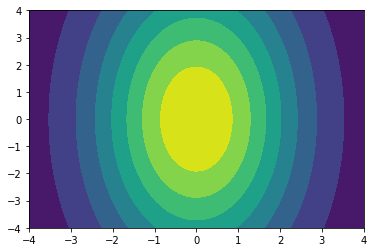

In [7]:
mu_x = 0
var_x = 3

mu_y = 0
var_y = 15

rv = multivariate_normal([mu_x, mu_y], [[3, 0], [0, 15]])
pos = np.dstack((X, Y))
plt.contourf(xvals, yvals, rv.pdf(pos))

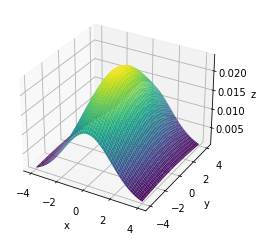

In [8]:
#Parameters to set


#Create grid and multivariate normal


rv = multivariate_normal([mu_x, mu_y], [[var_x, 0], [0, var_y]])

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [9]:
# simulation parameters
Ntraining = 25          # number of training points
ndim = 2        # model dimensions
Nsamples = 10000    # number of test points

In [10]:
def gaus_model(x, y):
    return np.random.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

In [11]:
gaus_model(0.5,0.6)

array([1.29479089, 0.08839912])

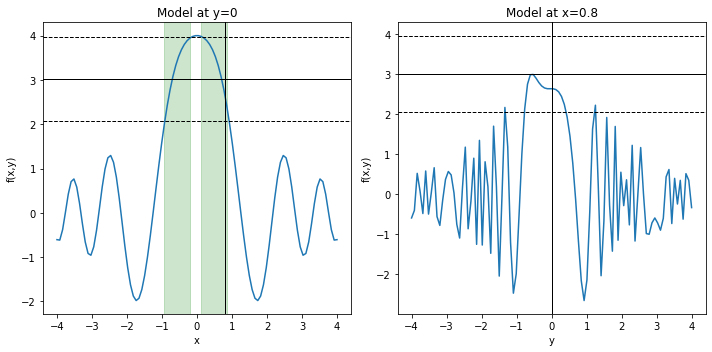

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
# x/y

func_x = model(xvals, true_y)
ax1.plot(xvals, func_x)
ax1.set_title('Model at y={}'.format(true_y))
ax1.set_xlabel('x')
ax1.set_ylabel('f(x,y)')
ax1.axvline(true_x, color='black', linewidth=1)
ax1.axhline(z_1, color='black', linewidth=1)
ax1.axhline(z_1+3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--')
ax1.axhline(z_1-3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--')

xidx1 = np.argwhere(np.diff(np.sign( func_x - z_1+3*np.sqrt(var_exp)))).flatten()
xidx2 = np.argwhere(np.diff(np.sign( func_x - z_1-3*np.sqrt(var_exp)))).flatten()

for i in range(len(xidx1)):
    ax1.axvspan(xvals[xidx1][i], xvals[xidx2][i], color='green', alpha=0.2)


func_y = model(true_x, yvals)
ax2.plot(yvals, func_y)
ax2.set_title('Model at x={}'.format(true_x))
ax2.set_xlabel('y')
ax2.set_ylabel('f(x,y)')
ax2.axvline(true_y, color='black', linewidth=1)
ax2.axhline(z_1, color='black', linewidth=1)
ax2.axhline(z_1+3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--')
ax2.axhline(z_1-3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--')

yidx1 = np.argwhere(np.diff(np.sign( func_y - z_1+3*np.sqrt(var_exp)))).flatten()
yidx2 = np.argwhere(np.diff(np.sign( func_y - z_1-3*np.sqrt(var_exp)))).flatten()
for i in range(len(yidx2)):
    ax2.axvspan(yvals[yidx1][i], yvals[yidx2][i], color='green', alpha=0.2)
plt.tight_layout()

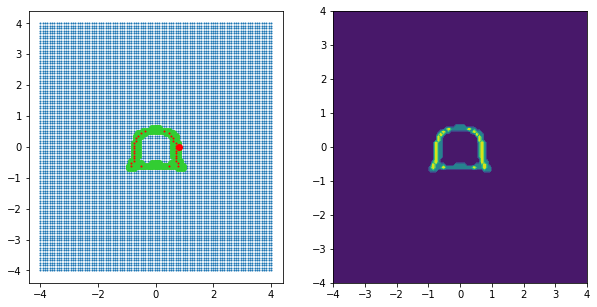

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))


ax1.scatter(X,Y, s=1)
idx = np.argwhere(np.logical_and(func_grid > z_1-1*np.sqrt(var_exp), func_grid < z_1+1*np.sqrt(var_exp)))

mean_idx = np.argwhere(np.diff(np.sign( func_grid - z_1)))

idxtest = np.argwhere(func_grid > z_1-3*np.sqrt(var_exp))

ax1.scatter(xvals[idx[:,1]], yvals[idx[:,0]], color='limegreen')
ax1.scatter(xvals[mean_idx[:,1]], yvals[mean_idx[:,0]], color='red', s = 1)

for i in range(len(idx)):
    xy_grid[idx[i,0], idx[i,1]] = 1
    
for i in range(len(mean_idx)):
    xy_grid[mean_idx[i,0], mean_idx[i,1]] = 2
    
ax1.scatter(true_x, true_y, color='red')

ax2.contourf(xvals, yvals, xy_grid, cmap='viridis')


In [14]:
# create squared-exponential kernel
sigma_cov = 0.2        # sqrt variance of covariance function
beta = 0         # prior expectation

kern = kernels.SE()

In [15]:
def history_match(true_model, parameter_bounds, sigma_cov, var_exp, beta, Ntraining, Nsamples, zlist, ndim, n_outputs, waves=1):
    
    # plot settings
    fig1, axes = plt.subplots(waves, 2, figsize=(12, 6*waves))
    ax_list = fig1.axes

    # find initial parameter volume
    initial_volume = 1
    for i in range(ndim):
        initial_volume = initial_volume * (parameter_bounds[i,1] - parameter_bounds[i,0])
    parameter_bounds_initial = parameter_bounds
    N_regions = 1

    Nsamples_0 = Nsamples
    Ntraining_0 = Ntraining
    for k in range(waves):
        
        ax1 = ax_list[2*k]
        ax2 = ax_list[2*k + 1]

        print('Current wave: ' + str(k+1))

        input_train_list = []
        input_test_list = []
        output_train_list = []

        # iterate over nonimplausible regions
        for n in range(N_regions):
            print('region: ' + str(n))

            # generate initial well spaced inputs for train and test sets
            if k == 0:
                input_train, input_test = data.prepare_data(ndim, Nsamples, Ntraining, parameter_bounds)
                # save this input for optical depth plots - clean later *******
                input_test_0 = input_test
            else:
                input_train = input_train_all[n]
                input_test = input_test_all[n]

            # iterate over model outputs
            implaus_all = np.zeros((len(input_test), n_outputs))

            for output in range(n_outputs):


                if k == 0:
                    # evaluate true model over training inputs
                    output_train = np.zeros(Ntraining)
                    true_model_vec = np.vectorize(true_model[output])
                    output_train = true_model_vec(*input_train.T)
                    # artificially add noise to observations
                    output_train += np.random.normal(0,var_exp)
                    
                else:
                    output_train = output_train_all[n][output]

                # build emulator over nonimplausible region
                GP = emulator.Gaussian_Process(input_train, input_test, output_train, sigma_cov, beta, kern)
                # optimise hyperparameters of emulator
                GP.optimise()
                # fit emulator using training points
                mu, cov, sd = GP.emulate()

                # evaluate implausibility over parameter volume
                for i in range(len(input_test)):
                    implaus_all[i, output] = historymatch.implausibility(mu[i], zlist[output], sd[i], 0, var_exp)
                    
            # choose maximum implausibility
            max_I = np.argmax(implaus_all, axis=1)
            implaus = np.choose(max_I, implaus_all.T)

            # identify implausible region
            input_imp = np.concatenate((input_test, implaus.reshape(-1,1)), axis=1)
            # if region empty, skip
            nonimplausible = np.delete(input_imp, np.where(input_imp[:,-1] > 3), axis=0)
            if nonimplausible.size == 0:
                print('empty')
                continue

            # plot implausibilities and optical depth
            variable_names = ['x', 'y', 'z']
            plot.implausibility_2D(input_imp, parameter_bounds_initial, ax1 , fig1, k, n, [0,1], 
                                   [variable_names[0], variable_names[1]], bins=20)
            
                        
            # isolate implausible regions based on greatest y difference
            implaus_regions = historymatch.find_clusters_3D(nonimplausible, input_test, ndim, parameter_bounds, n_grid=5)
            implaus_volumes = []
            implaus_N_pts = []
            # identify nonimplausible region boundaries and plot
            for i in range(len(implaus_regions)):

                group_i = implaus_regions[i]

                # plot first wave regions to visually check results
                #if k == 0:
                    
                    #ax2.set_title('Wave 1 Nonimplausible Regions')
                    #ax2.scatter(implaus_regions[i][:,0], implaus_regions[i][:,1], implaus_regions[i][:,2])
                    #ax2.set_xlabel('x')
                    #ax2.set_ylabel('y')
                    #ax2.set_zlabel('z')
                    #ax2.set_xlim([parameter_bounds_initial[0,0],parameter_bounds_initial[0,1]])
                    #ax2.set_ylim([parameter_bounds_initial[1,0],parameter_bounds_initial[1,1]])
                

                # find nonimplausible boundaries
                parameter_bounds = np.empty((0,2))
                volume = 1
                if group_i.shape[0] == 1:
                    for j in range(ndim):
                        min_i = group_i[:,j].min() - 0.01
                        max_i = group_i[:,j].max() + 0.01
                        parameter_bounds = np.concatenate((parameter_bounds, np.array([min_i, max_i]).reshape(1,-1)), axis=0)
                        volume = volume * (max_i - min_i)

                else:
                    for j in range(ndim):
                        min_i = group_i[:,j].min()
                        max_i = group_i[:,j].max()
                        parameter_bounds = np.concatenate((parameter_bounds, np.array([min_i, max_i]).reshape(1,-1)), axis=0)
                        volume = volume * (max_i - min_i)

                # rescale number of points to sample in parameter space
                implaus_volumes.append(volume)
                
            total_volume = sum(implaus_volumes)

            for i in range(len(implaus_regions)):
                
                print(implaus_regions[i].shape)

                Ntraining = int(np.ceil((implaus_volumes[i]/total_volume)*Ntraining))
                Nsamples = int(np.ceil((implaus_volumes[i]/total_volume)*Nsamples))

                # redefine nonimplausible space & generate new training points
                input_train_i, input_test_i = data.prepare_data(ndim, Nsamples, Ntraining, parameter_bounds)

                # evaluate true model over training inputs
                output_train_region = []
                for output in range(n_outputs):
                    output_train_i = np.zeros(len(input_train_i))
                    true_model_vec = np.vectorize(true_model[output])
                    output_train_i = true_model_vec(*input_train_i.T)
                    # artificially add noise to observations
                    output_train_i += np.random.normal(0,var_exp)
                    output_train_region.append(np.array(output_train_i))

                input_train_list.append(input_train_i)
                input_test_list.append(input_test_i)
                output_train_list.append(output_train_region)
        
        input_train_all = input_train_list

        input_test_all = input_test_list
        output_train_all = output_train_list

        N_regions = len(input_train_all)
        
        ax2.contourf(xvals, yvals, xy_grid, cmap='viridis')


Current wave: 1
region: 0
[0.12389625]


KeyboardInterrupt: 

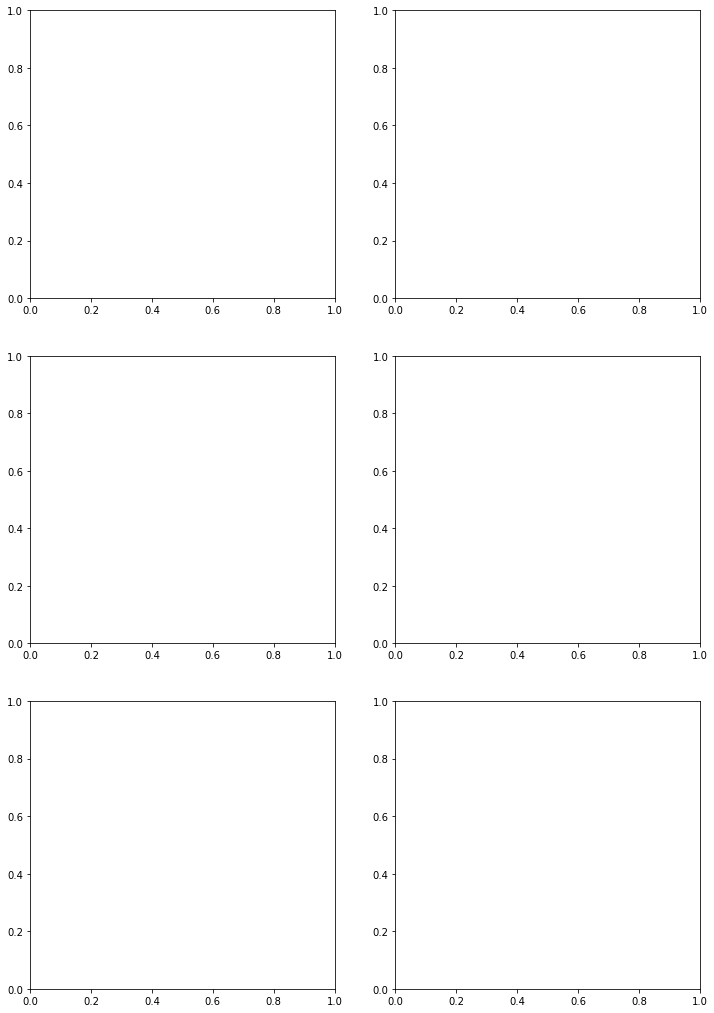

In [16]:
history_match([model_eqn], input_bounds, sigma_cov, var_exp, beta, 
              Ntraining, Nsamples, zlist=[z_1], ndim=2, n_outputs=1, waves=3)